<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Visualizing and tuning CARTs 


---

Using the admissions data from earlier in the course, build CARTs, look at how they work visually, and compare their performance to other models.

### 1. Install and load the packages required to visually show decision tree branching

You will need to first:

1. Install `graphviz` with homebrew (on OSX). The command will be `brew install graphviz`.
- Install `pydotplus` with `pip install pydotplus`.
- Load the packages as shown below (you may need to restart the kernel after the installations).

In [1]:
# REQUIREMENTS:
# pip install pydotplus
# brew install graphviz

### 2. Load in admissions data and other python packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
np.set_printoptions(precision=4)

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
admit = pd.read_csv(
    '../../../../../resource-datasets/admissions/admissions.csv')

### 3. Create regression and classification X, y data

The regression data will be:

    Xr = [admit, gre, prestige]
    yr = gpa
    
The classification data will be:

    Xc = [gre, gpa, prestige]
    yc = admit

In [4]:
# focus on data we have for the time being.
# dont want to spend an unessary amount of time cleaning.
admit = admit.dropna()
admit['prestige'] = admit['prestige'].astype(int)

In [5]:
admit.head()

admit    gre   gpa  prestige
0      0  380.0  3.61         3
1      1  660.0  3.67         3
2      1  800.0  4.00         1
3      1  640.0  3.19         4
4      0  520.0  2.93         4

In [6]:
Xr = admit[['admit', 'gre', 'prestige']]
Xr = pd.get_dummies(Xr, columns=['prestige'], drop_first=True)
yr = admit.gpa

Xc = admit[['gpa', 'gre', 'prestige']]
Xc = pd.get_dummies(Xc, columns=['prestige'], drop_first=True)
yc = admit.admit

### 4. Cross-validate linear regression and logistic regression on the data

Fit a linear regression for the regression problem and a logistic regression for the classification problem. Cross-validate the R2 and accuracy scores.

In [7]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score

In [8]:
# cross val Linear Reg 
lr = LinearRegression()
lr.fit(Xr, yr)
reg_scores = cross_val_score(lr, Xr, yr, cv=5)

# cross val Log Reg 
clf = LogisticRegression(penalty='none', max_iter=10000)
clf.fit(Xc, yc)
cls_scores = cross_val_score(clf, Xc, yc, cv=5)

# get scores
print(reg_scores, np.mean(reg_scores))
print(cls_scores, np.mean(cls_scores))

[ 0.2629  0.1998 -0.012   0.1775  0.085 ] 0.14263904536625543
[0.7125 0.725  0.6962 0.6835 0.6962] 0.7026898734177216


_Linear regression is overall terrible, Log reg is not bad...not great either_

### 5. Building regression trees

With `DecisionTreeRegressor`:

1. Build 4 models with different parameters for `max_depth`: `max_depth=1`, `max_depth=2`, `max_depth=3`, and `max_depth=None`
2. Cross-validate the R2 scores of each of the models and compare to the linear regression earlier.

In [9]:
from sklearn.tree import DecisionTreeRegressor

In [10]:
# set 4 models
dtr1 = DecisionTreeRegressor(max_depth=1)
dtr2 = DecisionTreeRegressor(max_depth=2)
dtr3 = DecisionTreeRegressor(max_depth=3)
dtrN = DecisionTreeRegressor(max_depth=None)

In [11]:
# fit the 4 models
dtr1.fit(Xr, yr)
dtr2.fit(Xr, yr)
dtr3.fit(Xr, yr)
dtrN.fit(Xr, yr)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [12]:
# cross validate the 4 models
dtr1_scores = cross_val_score(dtr1, Xr, yr, cv=5)
dtr2_scores = cross_val_score(dtr2, Xr, yr, cv=5)
dtr3_scores = cross_val_score(dtr3, Xr, yr, cv=5)
dtrN_scores = cross_val_score(dtrN, Xr, yr, cv=5)

# score the 4 models
print(dtr1_scores, np.mean(dtr1_scores))
print(dtr2_scores, np.mean(dtr2_scores))
print(dtr3_scores, np.mean(dtr3_scores))
print(dtrN_scores, np.mean(dtrN_scores))

[0.1411 0.1591 0.0341 0.1127 0.0781] 0.10503166699459247
[ 0.1811  0.2132 -0.001   0.1318  0.1389] 0.13279079678463254
[ 0.2468  0.2109 -0.0659  0.1821  0.1462] 0.14403817732042745
[-0.1248 -0.247  -0.3982 -0.7157 -0.0464] -0.30640595095976175


_The default score here is R2. None of the models did well, but the last one is even worse than baseline._

### 6. Visualizing the regression tree decisions

Use the template code below to create charts that show the logic/branching of your four decision tree regressions from above.

#### Interpreting a regression tree diagram

- First line is the condition used to split that node (go left if true, go right if false)
- `samples` is the number of observations in that node before splitting
- `mse` is the mean squared error calculated by comparing the actual response values in that node against the mean response value in that node
- `value` is the mean response value in that node


_For reference: this method of showing the model creates an output file using graphviz that then gets read in using pydotplus._

In [13]:
# TEMPLATE CODE
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [14]:
# initialize the output file object
dot_data = StringIO()

In [15]:
dtr1.max_depth

1

In [16]:
# my fit DecisionTreeRegressor object here is: dtr1
# for feature_names i put the columns of my Xr matrix


def plot_dt(dt, feature_names=None):
    print('Max depth:', dt.max_depth)
    dot_data = StringIO()
    export_graphviz(dt,
                    out_file=dot_data,
                    filled=True,
                    rounded=True,
                    special_characters=True,
                    feature_names=feature_names
                    )

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

Max depth: 1


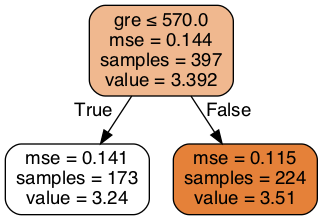

In [17]:
plot_dt(dtr1, feature_names=Xr.columns)

Max depth: 2


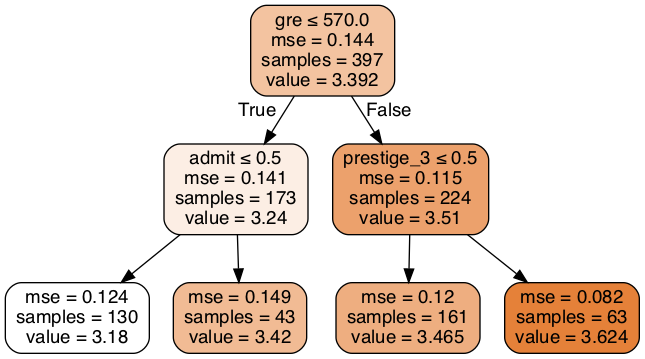

In [18]:
plot_dt(dtr2, feature_names=Xr.columns)

Max depth: 3


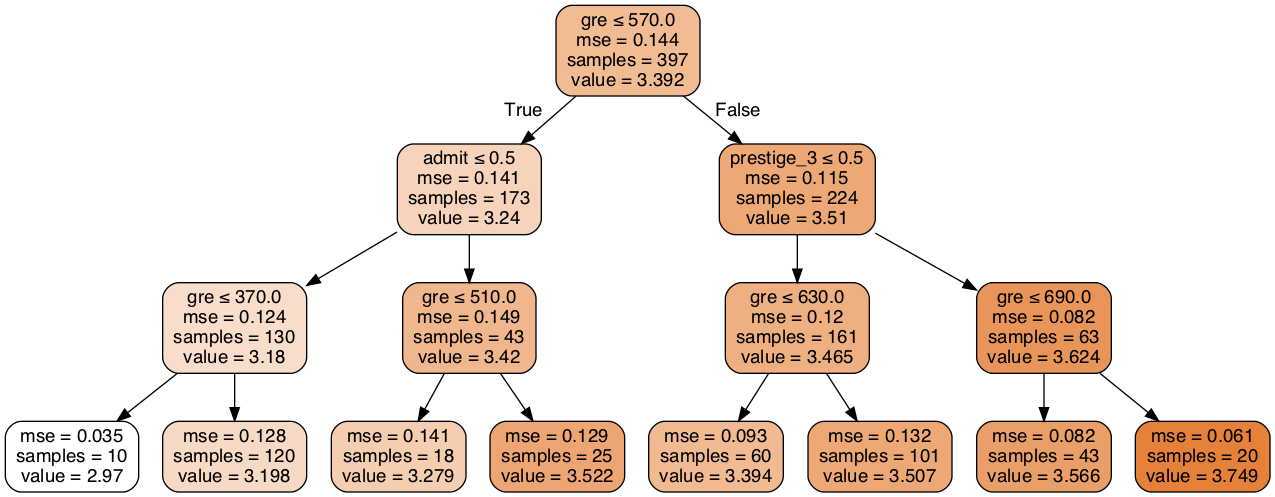

In [19]:
plot_dt(dtr3, feature_names=Xr.columns)

Max depth: None


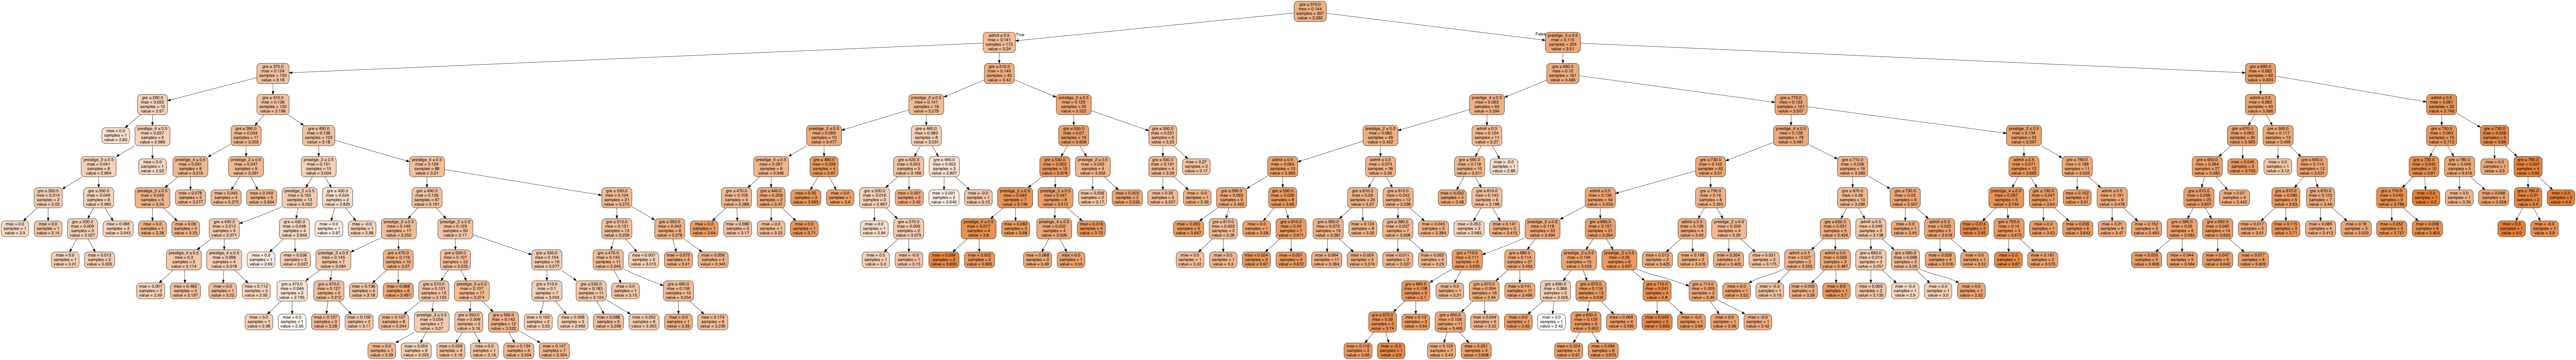

In [20]:
plot_dt(dtrN, feature_names=Xr.columns)

### 7. Building classification trees

With `DecisionTreeClassifier`:

1. Again build 4 models with different parameters for `max_depth`: `max_depth=1`, `max_depth=2`, `max_depth=3`, and `max_depth=None`
2. Cross-validate the accuracy scores of each of the models and compare to the logistic regression earlier.

Note that now you'll be using the classification task where we are predicting `admit`.

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
# set 4 trees
dtc1 = DecisionTreeClassifier(max_depth=1)
dtc2 = DecisionTreeClassifier(max_depth=2)
dtc3 = DecisionTreeClassifier(max_depth=3)
dtcN = DecisionTreeClassifier(max_depth=None)

In [23]:
# fit 4 trees
dtc1.fit(Xc, yc)
dtc2.fit(Xc, yc)
dtc3.fit(Xc, yc)
dtcN.fit(Xc, yc)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [24]:
# use CV to evaluate the 4 trees
dtc1_scores = cross_val_score(dtc1, Xc, yc, cv=5)
dtc2_scores = cross_val_score(dtc2, Xc, yc, cv=5)
dtc3_scores = cross_val_score(dtc3, Xc, yc, cv=5)
dtcN_scores = cross_val_score(dtcN, Xc, yc, cv=5)

print(dtc1_scores, np.mean(dtc1_scores))
print(dtc2_scores, np.mean(dtc2_scores))
print(dtc3_scores, np.mean(dtc3_scores))
print(dtcN_scores, np.mean(dtcN_scores))

[0.6875 0.675  0.6835 0.6835 0.6835] 0.682626582278481
[0.6875 0.6875 0.6582 0.6835 0.6076] 0.664873417721519
[0.6625 0.675  0.6582 0.6329 0.6203] 0.6497784810126582
[0.625  0.575  0.6203 0.5949 0.5316] 0.5893670886075949


*Classification does much better than its counterparts.  We can start to see how achieving completely pure leaves creates overfitting as `max_depth = None` is the worst performing model.*

### 8. Visualize the classification trees

The plotting code will be the same as for regression, you just need to change the model you're using for each plot and the feature names.

The output changes somewhat from the regression tree chart. Earlier it would give the MSE of that node, but now there is a line called `value` that tells you the count of each class at that node.

Max depth: 1


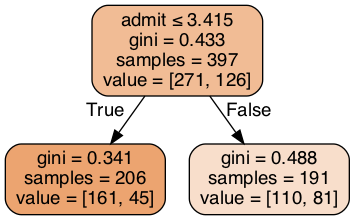

In [25]:
plot_dt(dtc1, feature_names=Xr.columns)

Max depth: 2


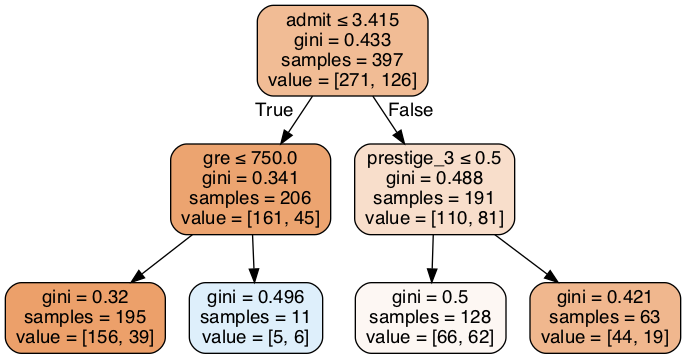

In [26]:
plot_dt(dtc2, feature_names=Xr.columns)

Max depth: 3


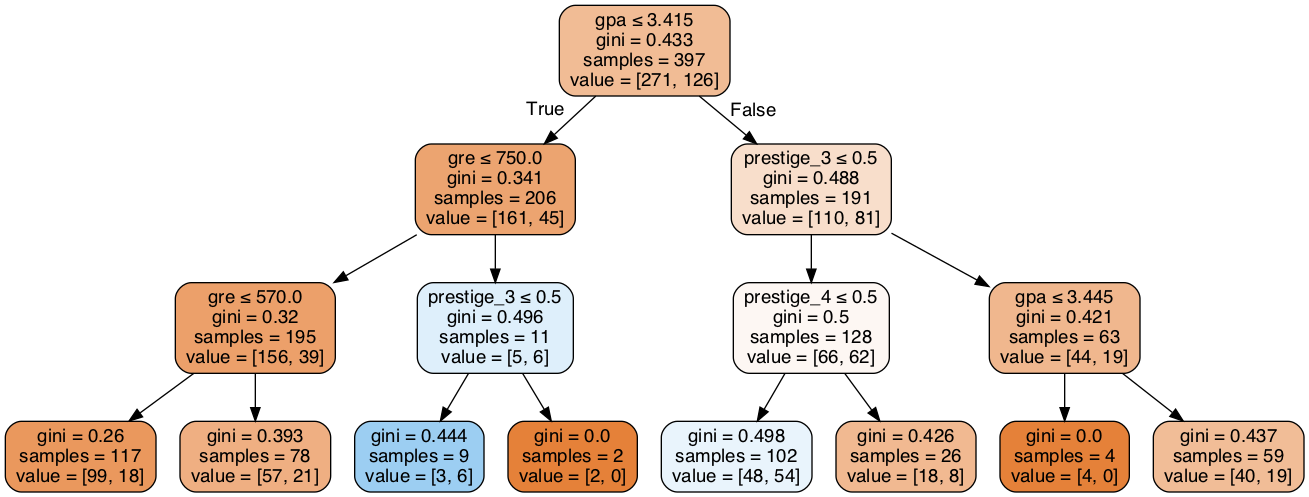

In [27]:
plot_dt(dtc3, feature_names=Xc.columns)

Max depth: None


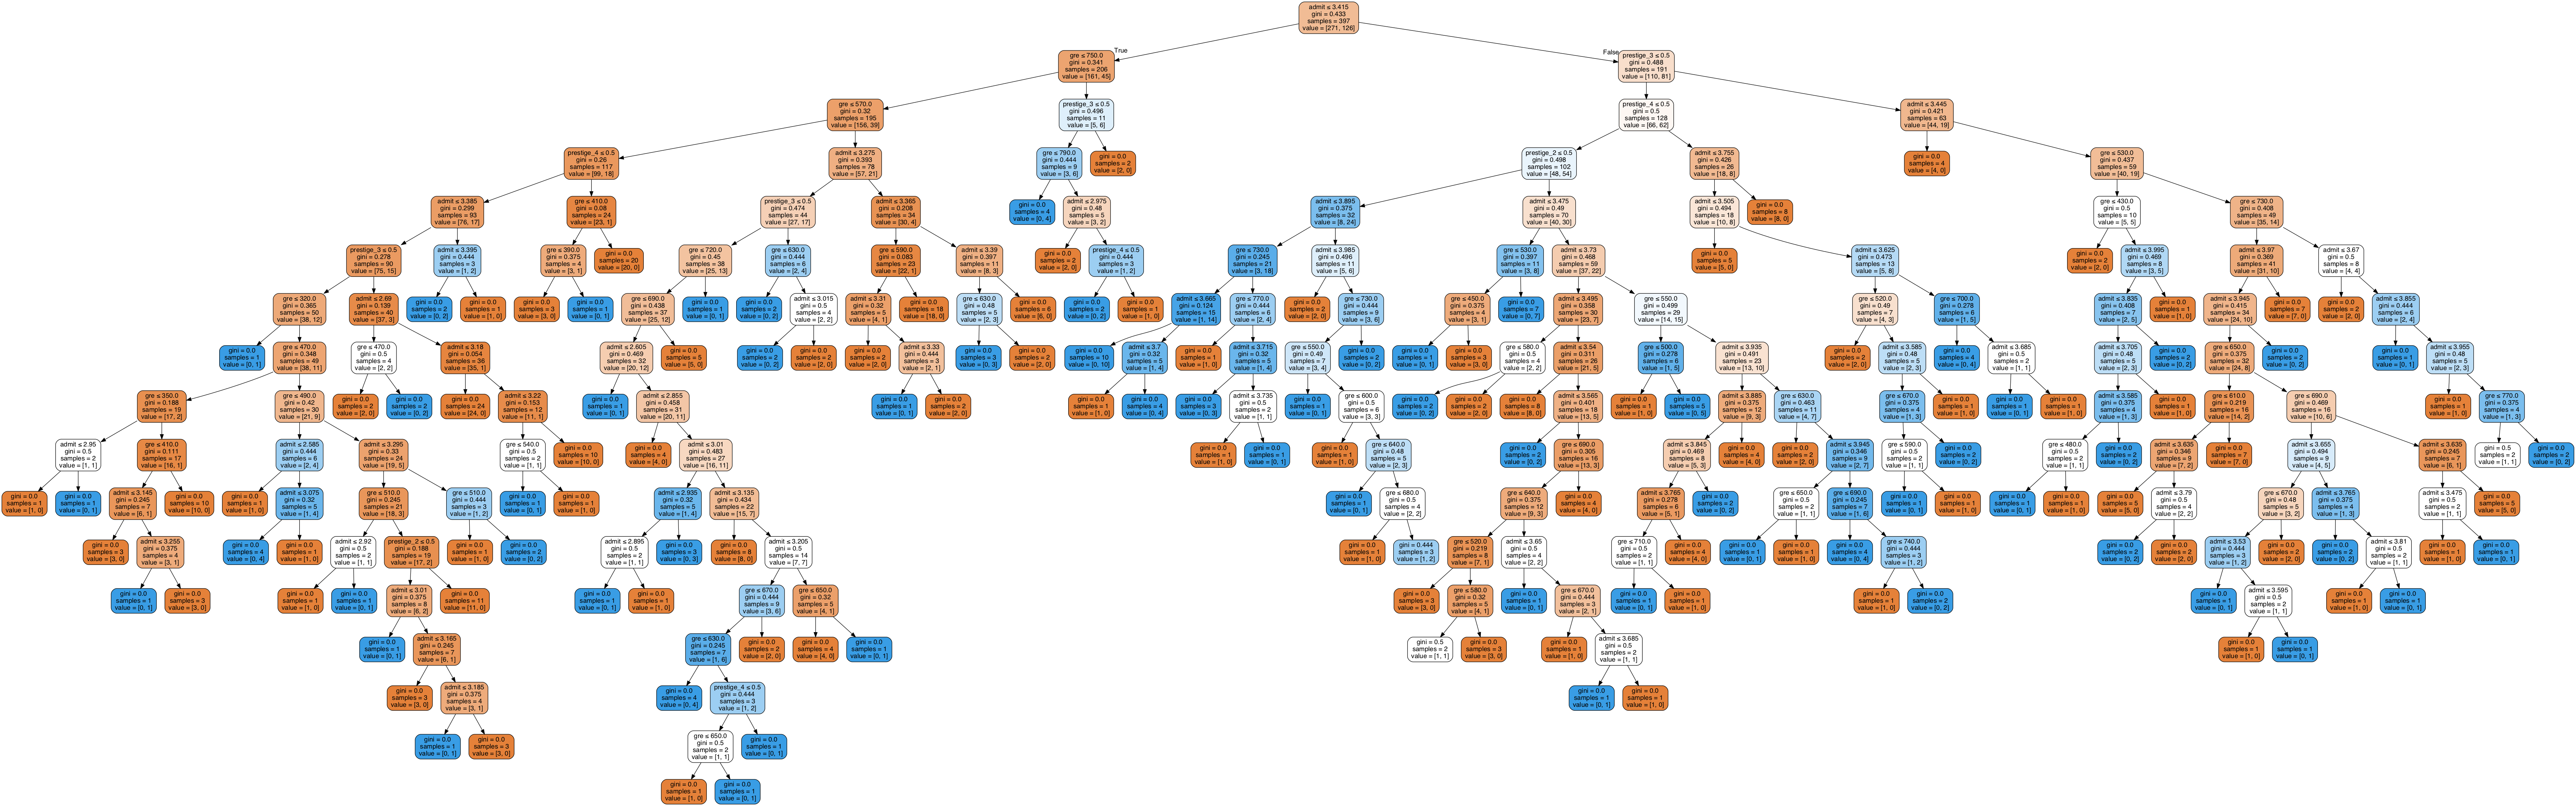

In [28]:
plot_dt(dtcN, feature_names=Xr.columns)

_Thats a lot of decisions!_

### 9. Using GridSearchCV to find the best decision tree classifier

As decision trees that are unrestricted will just end up overfitting the training data, decision tree regression and classification models in sklearn offer a variety of ways to "pre-prune" (by restricting how many times the tree can branch and what it can use).

Measure           | What it does
------------------|-------------
max_depth         | How many nodes deep can the decision tree go?
max_features      | Is there a cutoff to the number of features to use?
max_leaf_nodes    | How many leaves can be generated per tree?
min_samples_leaf  | How many samples need to be included at a leaf, at a minimum?  
min_samples_split | How many samples need to be included at a node, at a minimum?
ccp_alpha         | Associate a cost with the number of terminal nodes

It is not always best to search over _all_ of these in a grid search, unless you have a small dataset. Many of them while not redundant are going to have very similar effects on your model's fit.

Check out the documentation here:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

---

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
# gridsearch params
dtr_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}


# set the gridsearch
model = DecisionTreeRegressor()
dtr_gs = GridSearchCV(model, dtr_params, cv=5, verbose=1, n_jobs=2)

In [31]:
# use the gridearch model to fit the data
dtr_gs.fit(Xc, yc)
dtr_best = dtr_gs.best_estimator_
print(dtr_gs.best_params_)
print(dtr_gs.best_score_)

Fitting 5 folds for each of 1936 candidates, totalling 9680 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 778 tasks      | elapsed:    3.3s


{'ccp_alpha': 0.005, 'max_depth': 9, 'max_features': 1, 'min_samples_split': 4}
0.0340324737998454


[Parallel(n_jobs=2)]: Done 9646 tasks      | elapsed:   22.4s
[Parallel(n_jobs=2)]: Done 9677 out of 9680 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 9680 out of 9680 | elapsed:   22.4s finished


In [32]:
# gridsearch params
dtc_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}

# set the gridsearch
model = DecisionTreeClassifier()
dtc_gs = GridSearchCV(model, dtc_params, cv=5, verbose=1, n_jobs=2)

In [33]:
# use the gridearch model to fit the data
dtc_gs.fit(Xc, yc)
dtc_best = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1936 candidates, totalling 9680 fits


[Parallel(n_jobs=2)]: Done 1660 tasks      | elapsed:    3.5s


{'ccp_alpha': 0.005, 'max_depth': 10, 'max_features': 2, 'min_samples_split': 40}
0.7126265822784811


[Parallel(n_jobs=2)]: Done 9680 out of 9680 | elapsed:   20.0s finished


## Switch over to the college stats dataset

We are going to be predicting whether or not a college is public or private. Set up your X, y variables accordingly.

In [34]:
col = pd.read_csv('../../../../../resource-datasets/college_stats/College.csv')

In [35]:
col.head(2)

Unnamed: 0 Private  Apps  Accept  Enroll  Top10perc  \
0  Abilene Christian University     Yes  1660    1232     721         23   
1            Adelphi University     Yes  2186    1924     512         16   

   Top25perc  F.Undergrad  P.Undergrad  Outstate  Room.Board  Books  Personal  \
0         52         2885          537      7440        3300    450      2200   
1         29         2683         1227     12280        6450    750      1500   

   PhD  Terminal  S.F.Ratio  perc.alumni  Expend  Grad.Rate  
0   70        78       18.1           12    7041         60  
1   29        30       12.2           16   10527         56

In [36]:
y = col.Private.map(lambda x: 1 if x == 'Yes' else 0)
X = col.iloc[:, 2:]

In [37]:
y.mean()

0.7271557271557272

### 10. Set up and run the gridsearch on the data

In [38]:
# gridsearch params
from sklearn.model_selection import GridSearchCV
dtc_params = {
    'max_depth': [None]+list(range(1, 10)),
    'max_features': range(1, X.shape[1]+1),
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01]
}

# set the gridsearch
model = DecisionTreeClassifier()
dtc_gs = GridSearchCV(model, dtc_params, cv=5,
                      verbose=1, n_jobs=2, return_train_score=True)

In [39]:
# use the gridearch model to fit the data
dtc_gs.fit(X, y)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9350 candidates, totalling 46750 fits


[Parallel(n_jobs=2)]: Done 956 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done 5756 tasks      | elapsed:   19.3s
[Parallel(n_jobs=2)]: Done 13756 tasks      | elapsed:   46.8s
[Parallel(n_jobs=2)]: Done 24956 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 39356 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 46750 out of 46750 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=2,
             param_grid={'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01],
          

In [40]:
dtc_best = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

{'ccp_alpha': 0.005, 'max_depth': 9, 'max_features': 9, 'min_samples_split': 10}
0.9292224979321754


### 11. Print out the "feature importances"

The model has an attribute called `.feature_importances_` which will rank the features according to their importance. The ranking is based on an importance measure ranging from 0 to 1, with 1 being the most important. The importance scores of all features add up to 1.

The score takes into account how many times the feature was used to make a decision, how many data points were involved in each decision and how much the decision increased the purity of the node. A feature with higher feature importance reduced the criterion (impurity) more than the other features.

Below, show the feature importances for each variable predicting private versus not, sorted by most important feature to least.

In [41]:
fi = pd.DataFrame({
    'feature': X.columns,
    'importance': dtc_best.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi

feature  importance
5   F.Undergrad    0.605699
7      Outstate    0.338039
6   P.Undergrad    0.031181
8    Room.Board    0.025082
10     Personal    0.000000
15       Expend    0.000000
14  perc.alumni    0.000000
13    S.F.Ratio    0.000000
12     Terminal    0.000000
11          PhD    0.000000
0          Apps    0.000000
9         Books    0.000000
1        Accept    0.000000
4     Top25perc    0.000000
3     Top10perc    0.000000
2        Enroll    0.000000
16    Grad.Rate    0.000000

In [42]:
# Looks like there are several features which do not help to make decisions.